# Importing needed packages and Main Parameters

In [94]:
# Standard:
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
import os
import sys

# From utils.py
levels = 2
sys.path.append(os.path.abspath(os.path.join(".", "../"*levels)))
import utils

# Prophet Package:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_from_dict, model_to_dict, model_from_json, model_to_json, SIMPLE_ATTRIBUTES

# Hyperopt:
from hyperopt import fmin, tpe, hp, anneal, Trials, SparkTrials, STATUS_OK, space_eval

# Definitions:
granularity = "Monthly"
category = "Non-domestic"

# Input Paths:
demand_path = "../../data/gross_demand_daily.parquet"
h_weather_path = "../../data/gb_historic_hourly_weather.parquet"
h_average_weather_path = "../../data/gb_average_hourly_weather.parquet"
daylight_path = "../../data/gb_astronomical_data.parquet"

# Output Paths:
outputs_path = "../../outputs/monthly"

# Default parameters for scoring models:
monthly_cross_val_horizon = '366 days'
monthly_initial = '1095 days'
monthly_period = '180 days'

# Do not show Warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress log messages from cmdstanpy and prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

pd.options.display.max_columns = 100

## Dictionaries to be used for regressors:

In [95]:
gdp_dict = {"ds" : [2015_1,2015_2,2015_3,2015_4,2015_5,2015_6,2015_7,2015_8,2015_9,2015_10,2015_11,2015_12,2016_1,2016_2,2016_3,2016_4,2016_5,2016_6,2016_7,2016_8,2016_9,2016_10,2016_11,2016_12,2017_1,2017_2,2017_3,2017_4,2017_5,2017_6,2017_7,2017_8,2017_9,2017_10,2017_11,2017_12,2018_1,2018_2,2018_3,2018_4,2018_5,2018_6,2018_7,2018_8,2018_9,2018_10,2018_11,2018_12,2019_1,2019_2,2019_3,2019_4,2019_5,2019_6,2019_7,2019_8,2019_9,2019_10,2019_11,2019_12,2020_1,2020_2,2020_3,2020_4,2020_5,2020_6,2020_7,2020_8,2020_9,2020_10,2020_11,2020_12,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,2021_10,2021_11,2021_12,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10,2022_11,2022_12,2023_1,2023_2,2023_3,2023_4,2023_5,2023_6,2023_7,2023_8,2023_9,2023_10,2023_11,2023_12,2024_1,2024_2,2024_3,2024_4,2024_5,2024_6,2024_7,2024_8,2024_9,2024_10,2024_11,2024_12,2025_1,2025_2,2025_3,2025_4,2025_5,2025_6,2025_7,2025_8,2025_9,2025_10,2025_11,2025_12,2026_1,2026_2,2026_3,2026_4,2026_5,2026_6,2026_7,2026_8,2026_9,2026_10,2026_11,2026_12,2027_1,2027_2,2027_3,2027_4,2027_5,2027_6,2027_7,2027_8,2027_9,2027_10,2027_11,2027_12,2028_1,2028_2,2028_3,2028_4,2028_5,2028_6,2028_7,2028_8,2028_9,2028_10,2028_11,2028_12,2029_1,2029_2,2029_3,2029_4,2029_5,2029_6,2029_7,2029_8,2029_9,2029_10,2029_11,2029_12,2030_1,2030_2,2030_3,2030_4,2030_5,2030_6,2030_7,2030_8,2030_9,2030_10,2030_11,2030_12,2031_1,2031_2,2031_3], "gdp" : [91.687,91.961,92.0195,92.5513,92.3066,92.2139,92.6526,92.5197,92.6516,93.0295,92.8692,93.2685,93.2419,93.5345,93.7219,94.2234,94.0166,94.1336,94.2428,94.5378,95.0462,94.737,95.2482,95.9471,96.0813,96.1087,96.2108,96.613,96.7602,96.7748,96.9762,97.1614,97.5765,97.6088,97.8274,98.0528,97.8321,97.8775,98.0007,97.769,98.0835,98.4296,98.2858,98.4504,98.5964,98.495,98.7516,98.4909,98.8571,99.5299,99.5556,99.3054,99.5938,100.0858,100.5729,100.2885,100.6168,100.4694,100.3002,100.8246,100.8145,100.444,92.7769,74.5691,76.1555,83.5776,89.126,91.8198,93.026,93.5677,91.6681,92.8976,90.3167,91.2726,93.3356,96.7661,98.2848,99.4212,98.8991,99.7767,100.3606,100.7081,101.4433,100.9219,101.4331,101.966,102.1056,101.8883,102.5782,101.5609,101.9985,102.0639,101.4602,102.1466,102.205,101.8905,102.4213,102.5735,102.2569,102.4903,102.2648,103.0142,102.3513,102.5317,102.666627583333,102.6837162,102.70089381785,102.752095055675,102.8033865386,102.854945158577,102.906223198259,102.957591618408,103.009227576315,103.060582533056,103.112028005836,103.163741417679,103.215173406855,103.266696047844,103.318487029806,103.455844728899,103.593444528767,103.731760977925,103.869668107815,104.007818306882,104.146688021837,104.285146780246,104.423849580109,104.563274773924,104.702287367367,104.84154497843,104.98152787302,105.147265637552,105.313295524342,105.480190130416,105.646715149331,105.813533678082,105.981221033536,106.14853704629,106.316147963053,106.484631833445,106.65274259726,106.821149665878,106.990433834654,107.159343124597,107.328550126791,107.498638395369,107.668350004439,107.838360739893,108.009256927747,108.17977466696,108.350592953407,108.522300898154,108.693628596628,108.865258269936,109.03778182742,109.218983411675,109.40050437405,109.582970736557,109.765078328733,109.94750689592,110.13088559024,110.313903720377,110.4972444304,110.681540018191,110.865473238978,111.049730652552,111.234947718282,111.419800605173,111.604979305814,111.791122456873,111.976899608199,112.163004202343,112.350078069157,112.53678410624,112.723819223355,112.911828459503,113.099468026771,113.287438319472,113.476387601801,113.664965366905,113.853875511069,114.04376953981,114.23329019374,114.423144888625,114.613988387509,114.804456644708,114.995260613068,115.187058329446,115.378478927932,115.570236916133,115.762993621094,115.955371322572,116.148088100714,116.341808589199,116.535148179184] }

dict_integers = {'is_jan' : int,
'is_feb' : int,
'is_leap': int,
'is_mar' : int,
'is_apr' : int,
'is_may' : int,
'is_jun' : int,
'is_jul' : int,
'is_aug' : int,
'is_sep' : int,
'is_oct' : int,
'is_nov' : int,
'is_dec' : int}

dict_integers2 = {'abnormal' : int,
'covid_1' : int,
'covid_2' : int,
'covid_3' : int}

# Data Manipulation

## Weather and Bank Holidays Adjusted/Corrected Demand Table as pd.DataFrame

In [96]:
# Demand DataFrame
df = pd.read_parquet(demand_path).rename(columns={'settlement_date' : 'date'})
df['date'] = df['date'].apply(lambda dt: dt.replace(day=1))
df = df.groupby(by=['date', 'sector'])[['total_corrected_consumption_gwh']].sum().reset_index()
df = df[ (df['sector'] == category)].rename(columns={
  'total_corrected_consumption_gwh': 'y',
  'date': 'ds'}).reset_index(drop=True).sort_values('ds')
df
initial_date = df['ds'].min()
final_date = df['ds'].max()
initial_year = initial_date.year
final_year = final_date.year

## Regressors and Seasonality Tables as pd.DataFrame
- Extra regressors that could be added:
  - Hours of daylight a month.
  - Number of weekends for Domestic Data.
  - etc.

In [97]:
# Regressors DataFrame

# Monthly Seasonality as a Binary + Accounting for leap years.
aux = pd.DataFrame({'ds' : pd.date_range(start=initial_date, end='2050-03-01', freq='MS')})

month_binary = aux.copy()
month_binary['is_jan'] = month_binary['ds'].dt.month == 1
month_binary['is_feb'] = month_binary['ds'].dt.month == 2
month_binary['is_leap'] = month_binary['ds'].apply(lambda x: calendar.isleap(x.year) & (x.month == 2))
month_binary['is_mar'] = month_binary['ds'].dt.month == 3
month_binary['is_apr'] = month_binary['ds'].dt.month == 4
month_binary['is_may'] = month_binary['ds'].dt.month == 5
month_binary['is_jun'] = month_binary['ds'].dt.month == 6
month_binary['is_jul'] = month_binary['ds'].dt.month == 7
month_binary['is_aug'] = month_binary['ds'].dt.month == 8
month_binary['is_sep'] = month_binary['ds'].dt.month == 9
month_binary['is_oct'] = month_binary['ds'].dt.month == 10
month_binary['is_nov'] = month_binary['ds'].dt.month == 11
month_binary['is_dec'] = month_binary['ds'].dt.month == 12
month_binary = month_binary.astype(dict_integers)

# Number of Weekdays in each month/year.
weekdays = aux.copy()
weekdays['weekdays'] = weekdays['ds'].apply(lambda x: np.busday_count(datetime.date(x.year,x.month,x.day), datetime.date(x.year,x.month,x.day) + datetime.timedelta(calendar.monthrange(x.year,x.month)[1])))
base_regressors = month_binary.merge(weekdays, how='left', on='ds')

# Non-domestic statistical outliers [Mostly COVID]
covid_binary = aux.copy()
covid_binary['abnormal'] = covid_binary['ds'].isin(['2016-01-01','2019-09-01']) # 2019 pre-Brexit hike in prod.
covid_binary['covid_1'] = covid_binary['ds'].isin(['2021-03-01','2021-04-01'])
covid_binary['covid_2'] = covid_binary['ds'].isin(['2020-09-01','2020-10-01','2021-12-01'])
covid_binary['covid_3'] = covid_binary['ds'].isin(['2020-12-01','2021-11-01'])
covid_binary = covid_binary.astype(dict_integers2)

# Non-domestic GDP regressor.
gdp_final = pd.DataFrame(gdp_dict)
gdp_final['ds'] = gdp_final['ds'].apply(lambda x: datetime.date(int(str(x)[:4]),int(str(x)[4:]),1))
gdp_final['ds'] = pd.to_datetime(gdp_final['ds'])
monthly_regressors = gdp_final.merge(covid_binary, how='right', on='ds').merge(base_regressors, how='left', on='ds')

default_regressors = monthly_regressors.drop(columns='ds').columns.to_list()

## Merging Demand df with Regressors, Seasonality, etc.

In [98]:
df = df.merge(monthly_regressors, how='inner', on='ds')

## Creating future DataFrame for forecasting with the utilised Regressors, Seasonality, etc.

In [99]:
# Future df
future_df = pd.DataFrame({'ds': pd.date_range(start=initial_date, end=final_date + datetime.timedelta(days=365), freq='MS')})
future_df['sector'] = category
future_df = future_df.merge(monthly_regressors, how='left', on='ds')

# Modelling

## Dummy Model Initialisation for easier Hyper-parameters' optimisation spaces

In [100]:
# Forecasting Timeseries - Initializing a 

model = Prophet( # Default values
  growth = 'linear',
  seasonality_mode = 'multiplicative',
  holidays_mode = 'multiplicative',
  changepoints=None,
  n_changepoints=25,
  changepoint_range=0.9,
  holidays=None,
  seasonality_prior_scale=10.0,
  holidays_prior_scale=10.0,
  changepoint_prior_scale=0.05,
  mcmc_samples=0,
  interval_width=0.80,
  uncertainty_samples=1000,
  yearly_seasonality = False,
  weekly_seasonality = False,
  daily_seasonality = False
)

for reg in default_regressors:
  model.add_regressor(reg,
                      mode='multiplicative')
  

## HyperOpt Search Distributions, Search Spaces, Search Algorithm, etc.

In [105]:
# HyperOpt:

monthly_base_tuning = ['changepoint_prior_scale', 'changepoint_range']

monthly_base_hyperopt = {
  'changepoint_prior_scale': (0.001, 0.05),
  'changepoint_range' : (0.8, 0.9)}

monthly_non_dom_regressors = {
  'gdp' : (5, 10),
  'is_jan' : (0, 0.5),
  'is_feb' : (0, 0.5),
  'is_leap' : (0, 0.5),
  'is_mar' : (0, 0.5),
  'is_apr' : (0, 0.5),
  'is_may' : (0, 0.5),
  'is_jun' : (0, 0.5),
  'is_jul' : (0, 0.5),
  'is_aug' : (0, 0.5),
  'is_sep' : (0, 0.5),
  'is_oct' : (0, 0.5),
  'is_nov' : (0, 0.5),
  'is_dec' : (0, 0.5),
  'weekdays' : (0, 0.5),
  'covid_1' : (0, 5),
  'covid_2' : (0, 5),
  'covid_3' : (0, 5),
  'abnormal' : (0, 5)
  }

space = {}
space_dict = {}

# Creating the HyperOpt Space for the tuning [We could use log instead of uniform?]
for item in monthly_base_tuning:
  space[item] = hp.uniform(item, monthly_base_hyperopt[item][0], monthly_base_hyperopt[item][1])
  space_dict[item] = ('hp.uniform', monthly_base_hyperopt[item][0], monthly_base_hyperopt[item][1])

for item in [i for i in model.extra_regressors]:
  space[item] = hp.uniform(item, monthly_non_dom_regressors[item][0], monthly_non_dom_regressors[item][1])
  space_dict[item] = ('hp.uniform', monthly_non_dom_regressors[item][0], monthly_non_dom_regressors[item][1])

# HyperOpt algorithm and +
algo = tpe.suggest
max_evals = 10
trials = Trials()
rstate = np.random.default_rng(42)

## Function for HyperOpt to run.
- The function is literally a model fitting with the HyperOpt variables and scoring depending on the cross_validation's metric (MAPE here)

In [106]:
def hyperopt_tuning(hyperopt):

  global model

  # Creating the forecasting model with the variables we are using: multiplicative, holidays, regressors, seasonalities.
  model = Prophet( # Default values
    growth = 'linear',
    seasonality_mode = 'multiplicative',
    holidays_mode = 'multiplicative',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.9,
    holidays=None,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.80,
    uncertainty_samples=1000,
    yearly_seasonality = False,
    weekly_seasonality = False,
    daily_seasonality = False
  )

  for reg in default_regressors:
    model.add_regressor(reg,
                        mode='multiplicative')


  # Using Hyperopt to tune the base hyperparams: changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range.
  for hyperparam in monthly_base_tuning:
    setattr(model, hyperparam, hyperopt[hyperparam])


  # Using Hyperopt to tune the extra hyperparams: regressors unique to the model.
  for regressor_hyperparam in [i for i in model.extra_regressors]:
    model.extra_regressors[regressor_hyperparam]['prior_scale'] = hyperopt[regressor_hyperparam]


  # Fitting the model with the hyperopt variables to optimize them using the aglorithm "Tree of Parzen Estimators" by default. This can be changed.
  model.fit(df)


  # Scoring parameters for each iteration in the optimization.
  df_cv = cross_validation(model, initial=monthly_initial, period=monthly_period, horizon=monthly_cross_val_horizon)
  df_p = performance_metrics(df_cv, rolling_window=1)
  df_p['cutoff_points'] = len(df_cv['cutoff'].unique())
  score = df_p['mape'].values[0]


  return {
  'loss' : score,
  'status' : STATUS_OK,
  'cutoff_points' : df_p['cutoff_points'][0], 
  'horizon_days' : df_p['horizon'][0].days,
  'metrics' : dict(zip(df_p.columns[1:-2], df_p.values[0][1:-2])),
  'prophet_dict' : model_to_dict(model),
  'category' : category,
  'granularity' : granularity,
  'hopt_algorithm' : algo.__module__,
  'max_iters' : max_evals,
  'random_state' : rstate,
  'training_datetime' : datetime.datetime.today()
  } 

In [107]:
# Hyperparameter Optimisation: Getting the "best" prior distributions
hyperopt_optimization = fmin(fn=hyperopt_tuning,
                              space = space,
                              algo= algo,
                              max_evals=max_evals,
                              trials= trials,
                              rstate= rstate)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.69s/trial, best loss: 0.055307066322500084]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:03<00:13,  1.69s/trial, best loss: 0.055307066322500084]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:04<00:10,  1.56s/trial, best loss: 0.055307066322500084]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:06<00:09,  1.59s/trial, best loss: 0.05500412429389078] 

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:07<00:07,  1.57s/trial, best loss: 0.05500412429389078]

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:09<00:06,  1.61s/trial, best loss: 0.05500412429389078]

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:11<00:04,  1.61s/trial, best loss: 0.05500412429389078]

  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:12<00:03,  1.58s/trial, best loss: 0.051805828947149246]

  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:14<00:01,  1.59s/trial, best loss: 0.051805828947149246]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.60s/trial, best loss: 0.051805828947149246]


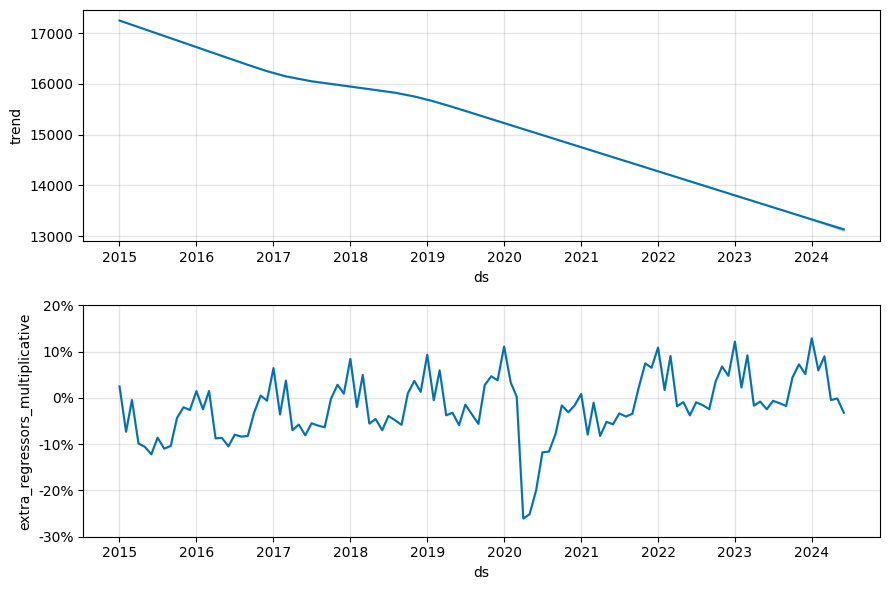

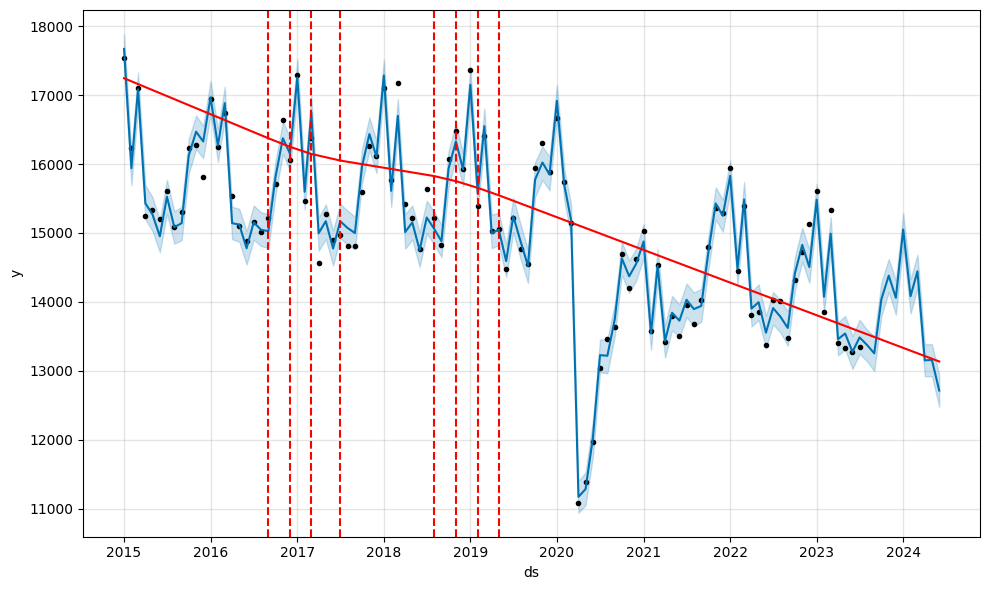

In [108]:
# Plotting the model's components and forecast including Backcast
best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
fig = best_model.plot_components(forecast)
plt.show()
fig = best_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, forecast)
plt.show()

# Prophet() Formulas, components, etc. understanding

## Looking into the components within the Prophet Python Object

In [109]:
### Parameters of the best model (Look for definitions in PPT)
# lp >> Log posterior density of the model parameters.
# k >> Growth rate parameter (slope).
# m >> initial intercept.
# delta [preprocess S size] >> slope change at each changepoint.
# sigma_obs >> standard deviation of the observations.
# beta [preprocess K size] >> coefficients for seasonality, holidats, regressors.
# trend [preprocess T size] >> estimated trend at each datetime.

best_model = model_from_dict(trials.best_trial['result']['prophet_dict'])
forecast = best_model.predict(future_df)
print([x for x in best_model.params])
[best_model.params[x].size for x in best_model.params]

['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']


[1, 1, 1, 25, 1, 19, 103]

In [110]:
# Default forecast DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,abnormal,abnormal_lower,abnormal_upper,covid_1,covid_1_lower,covid_1_upper,covid_2,covid_2_lower,covid_2_upper,covid_3,covid_3_lower,covid_3_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,gdp,gdp_lower,gdp_upper,is_apr,is_apr_lower,is_apr_upper,is_aug,is_aug_lower,is_aug_upper,is_dec,is_dec_lower,is_dec_upper,is_feb,is_feb_lower,is_feb_upper,is_jan,is_jan_lower,is_jan_upper,is_jul,is_jul_lower,is_jul_upper,is_jun,is_jun_lower,is_jun_upper,is_leap,is_leap_lower,is_leap_upper,is_mar,is_mar_lower,is_mar_upper,is_may,is_may_lower,is_may_upper,is_nov,is_nov_lower,is_nov_upper,is_oct,is_oct_lower,is_oct_upper,is_sep,is_sep_lower,is_sep_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekdays,weekdays_lower,weekdays_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,17245.597107,17426.975555,17923.195262,17245.597107,17245.597107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024664,0.024664,0.024664,-0.046754,-0.046754,-0.046754,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.070344,0.070344,0.070344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024664,0.024664,0.024664,0.001074,0.001074,0.001074,0.0,0.0,0.0,17670.937655
1,2015-02-01,17201.254462,15696.792263,16170.619673,17201.254462,17201.254462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.073305,-0.073305,-0.073305,-0.044284,-0.044284,-0.044284,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.022194,-0.022194,-0.022194,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.073305,-0.073305,-0.073305,-0.006827,-0.006827,-0.006827,0.0,0.0,0.0,15940.323470
2,2015-03-01,17161.203041,16836.450706,17315.887425,17161.203041,17161.203041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004468,-0.004468,-0.004468,-0.043756,-0.043756,-0.043756,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038214,0.038214,0.038214,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004468,-0.004468,-0.004468,0.001074,0.001074,0.001074,0.0,0.0,0.0,17084.524622
3,2015-04-01,17116.860396,15176.367981,15674.765492,17116.860396,17116.860396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.098591,-0.098591,-0.098591,-0.038961,-0.038961,-0.038961,-0.060705,-0.060705,-0.060705,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.098591,-0.098591,-0.098591,0.001074,0.001074,0.001074,0.0,0.0,0.0,15429.285843
4,2015-05-01,17073.948161,15025.118010,15531.648717,17073.948161,17073.948161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105708,-0.105708,-0.105708,-0.041167,-0.041167,-0.041167,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.061664,-0.061664,-0.061664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105708,-0.105708,-0.105708,-0.002877,-0.002877,-0.002877,0.0,0.0,0.0,15269.103116


In [112]:
# 1 for each coefficient
# There are 3 columns grouping holidays, regressors and all terms: holidays, extra_regressors_multiplicative, multiplicative_terms.
# Dropping them, the sum of 1s if beta [preprocess K size]

components = model.train_component_cols
print(components.drop(columns=['extra_regressors_multiplicative', 'multiplicative_terms']).sum().sum())
components.drop(columns=['extra_regressors_multiplicative', 'multiplicative_terms']).T.sum(axis=1)

19


component
abnormal          1
covid_1           1
covid_2           1
covid_3           1
gdp               1
is_apr            1
is_aug            1
is_dec            1
is_feb            1
is_jan            1
is_jul            1
is_jun            1
is_leap           1
is_mar            1
is_may            1
is_nov            1
is_oct            1
is_sep            1
weekdays          1
additive_terms    0
dtype: int64

In [113]:
# Coefficients and values of the extra_regressors
regressor_coefficients(best_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,gdp,multiplicative,96.871790,0.009018,0.009018,0.009018
1,abnormal,multiplicative,0.000000,-0.020117,-0.020117,-0.020117
2,covid_1,multiplicative,0.000000,-0.021797,-0.021797,-0.021797
3,covid_2,multiplicative,0.000000,0.022236,0.022236,0.022236
4,covid_3,multiplicative,0.000000,0.013532,0.013532,0.013532
5,is_jan,multiplicative,0.000000,0.070344,0.070344,0.070344
6,is_feb,multiplicative,0.000000,-0.022194,-0.022194,-0.022194
7,is_leap,multiplicative,0.000000,0.030575,0.030575,0.030575
8,is_mar,multiplicative,0.000000,0.038214,0.038214,0.038214
9,is_apr,multiplicative,0.000000,-0.060705,-0.060705,-0.060705


In [115]:
# Example of the normal distribution of the extra_regressor "temperature"
print(best_model.extra_regressors['gdp'])

{'prior_scale': 7.679158964299982, 'standardize': 'auto', 'mu': 96.87179029126214, 'std': 4.9214585823062444, 'mode': 'multiplicative'}


In [116]:
# All the extra_regressors' parameters
best_model.extra_regressors

OrderedDict([('gdp',
              {'prior_scale': 7.679158964299982,
               'standardize': 'auto',
               'mu': 96.87179029126214,
               'std': 4.9214585823062444,
               'mode': 'multiplicative'}),
             ('abnormal',
              {'prior_scale': 4.06514087203359,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_1',
              {'prior_scale': 1.7758353844386054,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_2',
              {'prior_scale': 1.5855718678345325,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'multiplicative'}),
             ('covid_3',
              {'prior_scale': 0.5225597639710444,
               'standardize': 'auto',
               'mu': 0.0,
  

In [117]:
# Looking at the Inputs we give the model after they've been preprocessed (scaling, etc)
[
  'K', # number of variables' coefficients [BETA size in model.params].
  'S', # number of slope changes (at each changepoint) [DELTA size in model.params].
  'T', # number of estimated values of the trend component of the time series at each time point. [TREND size in model.params].
  'X', # Dataframe of TxK (each time series point and the variables coefficients as columns).
  'cap', # for logistic growth.
  's_a', # additive terms.
  's_m', # multiplicative terms.
  'sigmas', # Coefficients' prior_scales (Hyperparameters)
  't', # time.
  't_change', # value of t at changepoints.
  'tau', # changepoint prior_scale >> flexibility.
  'trend_indicator',
  'y' # standardized y values.
  ]
preprocess = best_model.preprocess(df)
preprocess

ModelInputData(T=103, S=25, K=19, tau=0.040425225763782824, trend_indicator=0, y=0      1.000000
1      0.925868
2      0.975386
3      0.869632
4      0.874737
         ...   
98     0.874094
99     0.764263
100    0.760053
101    0.757062
102    0.760790
Name: y_scaled, Length: 103, dtype: float64, t=0      0.000000
1      0.009990
2      0.019014
3      0.029004
4      0.038672
         ...   
98     0.960683
99     0.970674
100    0.980342
101    0.990332
102    1.000000
Name: t, Length: 103, dtype: float64, cap=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), t_change=array(

In [118]:
# How the model parameters will be initialized under the number of regressors we are utilising:
print(best_model.calculate_initial_params(num_total_regressors=preprocess.K))

ModelParams(k=-0.23921032621128802, m=1.0, delta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), beta=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), sigma_obs=1.0)


In [119]:
## Saving model:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(best_model))  # Save model

In [120]:
## Reading model:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

# Post-processing

In [121]:
# Checking what are the input parameters and priors of the best model:
utils.hyper_params_df(trials)

,abnormal,changepoint_prior_scale,changepoint_range,covid_1,covid_2,covid_3,gdp,is_apr,is_aug,is_dec,is_feb,is_jan,is_jul,is_jun,is_leap,is_mar,is_may,is_nov,is_oct,is_sep,weekdays,cross_val_mape,cutoff_points,horizon_days,hopt_algorithm,max_iters,random_state,model_sector,model_granularity,model_mape,model_mdape,training_datetime
0,4.065141,0.040425,0.809824,1.775835,1.585572,0.52256,7.679159,0.147172,0.4133,0.006587,0.047929,0.360549,0.456416,0.166993,0.364248,0.368791,0.069905,0.16849,0.374018,0.415045,0.032143,0.051806,10,366,hyperopt.tpe,10,Generator(PCG64),Non-domestic,Monthly,0.051806,0.051806,2024-10-02 14:00:07.777044


In [122]:
# Getting well formatted forecasts, etc.
best_model.granularity = granularity
best_model.future = future_df
best_model.forecast = forecast
best_model.full_forecast = utils.full_forecast_df(best_model)
best_model.reduced_forecast = utils.reduced_forecast_df(best_model)

In [123]:
best_model.full_forecast

,ds,y,sector,nominal_gdp,nominal_abnormal,nominal_covid_1,nominal_covid_2,nominal_covid_3,nominal_is_jan,nominal_is_feb,nominal_is_leap,nominal_is_mar,nominal_is_apr,nominal_is_may,nominal_is_jun,nominal_is_jul,nominal_is_aug,nominal_is_sep,nominal_is_oct,nominal_is_nov,nominal_is_dec,nominal_weekdays,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,additive_terms,gdp,abnormal,covid_1,covid_2,covid_3,is_jan,is_feb,is_leap,is_mar,is_apr,is_may,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,weekdays,yearly,externalities,residual,error_percentage,yhat_detrended,training_datetime
0,2015-01-01,17535.797012,Non-domestic,91.687000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,22,17245.597107,17670.937655,17426.975555,17923.195262,17245.597107,17245.597107,0.024664,0.0,-0.046754,0.0,0.0,0.0,0.0,0.070344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,0.071418,0.0,135.140643,0.007707,1.039291,2024-10-02 14:02:03.880834
1,2015-02-01,16235.838323,Non-domestic,91.961000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20,17201.254462,15940.323470,15696.792263,16170.619673,17201.254462,17201.254462,-0.073305,0.0,-0.044284,0.0,0.0,0.0,0.0,0.000000,-0.022194,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.006827,-0.029021,0.0,-295.514853,-0.018201,0.940084,2024-10-02 14:02:03.880834
2,2015-03-01,17104.171944,Non-domestic,92.019500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,22,17161.203041,17084.524622,16836.450706,17315.887425,17161.203041,17161.203041,-0.004468,0.0,-0.043756,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.038214,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,0.039288,0.0,-19.647322,-0.001149,1.009014,2024-10-02 14:02:03.880834
3,2015-04-01,15249.697840,Non-domestic,92.551300,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22,17116.860396,15429.285843,15176.367981,15674.765492,17116.860396,17116.860396,-0.098591,0.0,-0.038961,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.060705,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,-0.059631,0.0,179.588003,0.011776,0.915750,2024-10-02 14:02:03.880834
4,2015-05-01,15339.201789,Non-domestic,92.306600,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21,17073.948161,15269.103116,15025.118010,15531.648717,17073.948161,17073.948161,-0.105708,0.0,-0.041167,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.061664,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002877,-0.064540,0.0,-70.098673,-0.004570,0.909669,2024-10-02 14:02:03.880834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2024-02-01,NaN,Non-domestic,102.854945,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,21,13291.847829,14082.162973,13847.713809,14333.255690,13276.213016,13307.152574,0.059459,0.0,0.053954,0.0,0.0,0.0,0.0,0.000000,-0.022194,0.030575,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002877,0.005505,0.0,NaN,NaN,1.077109,2024-10-02 14:02:03.880834
110,2024-03-01,NaN,Non-domestic,102.906223,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,21,13254.202550,14443.814170,14201.390287,14669.459540,13234.955516,13273.097668,0.089754,0.0,0.054416,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.038214,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.002877,0.035337,0.0,NaN,NaN,1.105202,2024-10-02 14:02:03.880834
111,2024-04-01,NaN,Non-domestic,102.957592,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,22,13213.961046,13151.175324,12898.010958,13397.034575,13190.381641,13236.681329,-0.004751,0.0,0.054879,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.060705,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001074,-0.059631,0.0,NaN,NaN,1.012114,2024-10-02 14:02:03.880834
112,2024-05-01,NaN,Non-domestic,103.009228,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,23,13175.017654,13157.965672,12912.531637,13385.552679,13146.804500,13202.582973,-0.001294,0.0,0.055345,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.061664,0

In [124]:
best_model.reduced_forecast

,ds,y,sector,nominal_gdp,nominal_weekdays,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,additive_terms,gdp,is_leap,weekdays,yearly,externalities,residual,error_percentage,yhat_detrended,training_datetime
0,2015-01-01,17535.797012,Non-domestic,91.687000,22,17245.597107,17670.937655,17426.975555,17923.195262,17245.597107,17245.597107,0.024664,0.0,-0.046754,0.000000,0.001074,0.071418,0.0,135.140643,0.007707,1.039291,2024-10-02 14:02:03.880834
1,2015-02-01,16235.838323,Non-domestic,91.961000,20,17201.254462,15940.323470,15696.792263,16170.619673,17201.254462,17201.254462,-0.073305,0.0,-0.044284,0.000000,-0.006827,-0.029021,0.0,-295.514853,-0.018201,0.940084,2024-10-02 14:02:03.880834
2,2015-03-01,17104.171944,Non-domestic,92.019500,22,17161.203041,17084.524622,16836.450706,17315.887425,17161.203041,17161.203041,-0.004468,0.0,-0.043756,0.000000,0.001074,0.039288,0.0,-19.647322,-0.001149,1.009014,2024-10-02 14:02:03.880834
3,2015-04-01,15249.697840,Non-domestic,92.551300,22,17116.860396,15429.285843,15176.367981,15674.765492,17116.860396,17116.860396,-0.098591,0.0,-0.038961,0.000000,0.001074,-0.059631,0.0,179.588003,0.011776,0.915750,2024-10-02 14:02:03.880834
4,2015-05-01,15339.201789,Non-domestic,92.306600,21,17073.948161,15269.103116,15025.118010,15531.648717,17073.948161,17073.948161,-0.105708,0.0,-0.041167,0.000000,-0.002877,-0.064540,0.0,-70.098673,-0.004570,0.909669,2024-10-02 14:02:03.880834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2024-02-01,NaN,Non-domestic,102.854945,21,13291.847829,14082.162973,13847.713809,14333.255690,13276.213016,13307.152574,0.059459,0.0,0.053954,0.030575,-0.002877,0.005505,0.0,NaN,NaN,1.077109,2024-10-02 14:02:03.880834
110,2024-03-01,NaN,Non-domestic,102.906223,21,13254.202550,14443.814170,14201.390287,14669.459540,13234.955516,13273.097668,0.089754,0.0,0.054416,0.000000,-0.002877,0.035337,0.0,NaN,NaN,1.105202,2024-10-02 14:02:03.880834
111,2024-04-01,NaN,Non-domestic,102.957592,22,13213.961046,13151.175324,12898.010958,13397.034575,13190.381641,13236.681329,-0.004751,0.0,0.054879,0.000000,0.001074,-0.059631,0.0,NaN,NaN,1.012114,2024-10-02 14:02:03.880834
112,2024-05-01,NaN,Non-domestic,103.009228,23,13175.017654,13157.965672,12912.531637,13385.552679,13146.804500,13202.582973,-0.001294,0.0,0.055345,0.000000,0.005025,-0.056639,0.0,NaN,NaN,1.013859,2024-10-02 14:02:03.880834


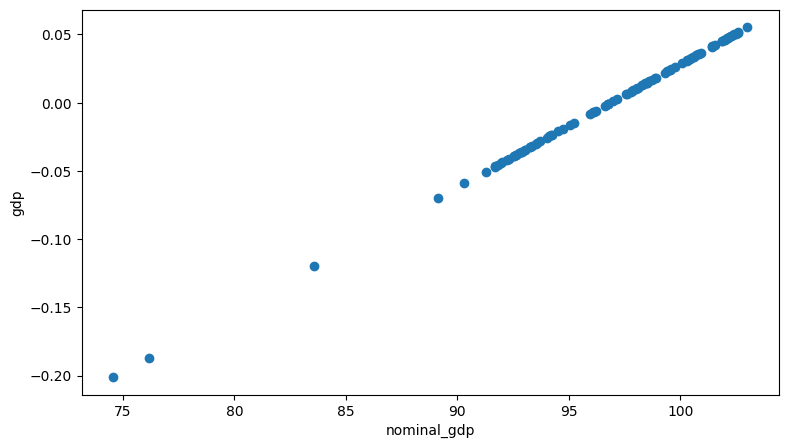

In [125]:
# Plotting Weather Regressors
fig = utils.plot_regressors_linearity(best_model)

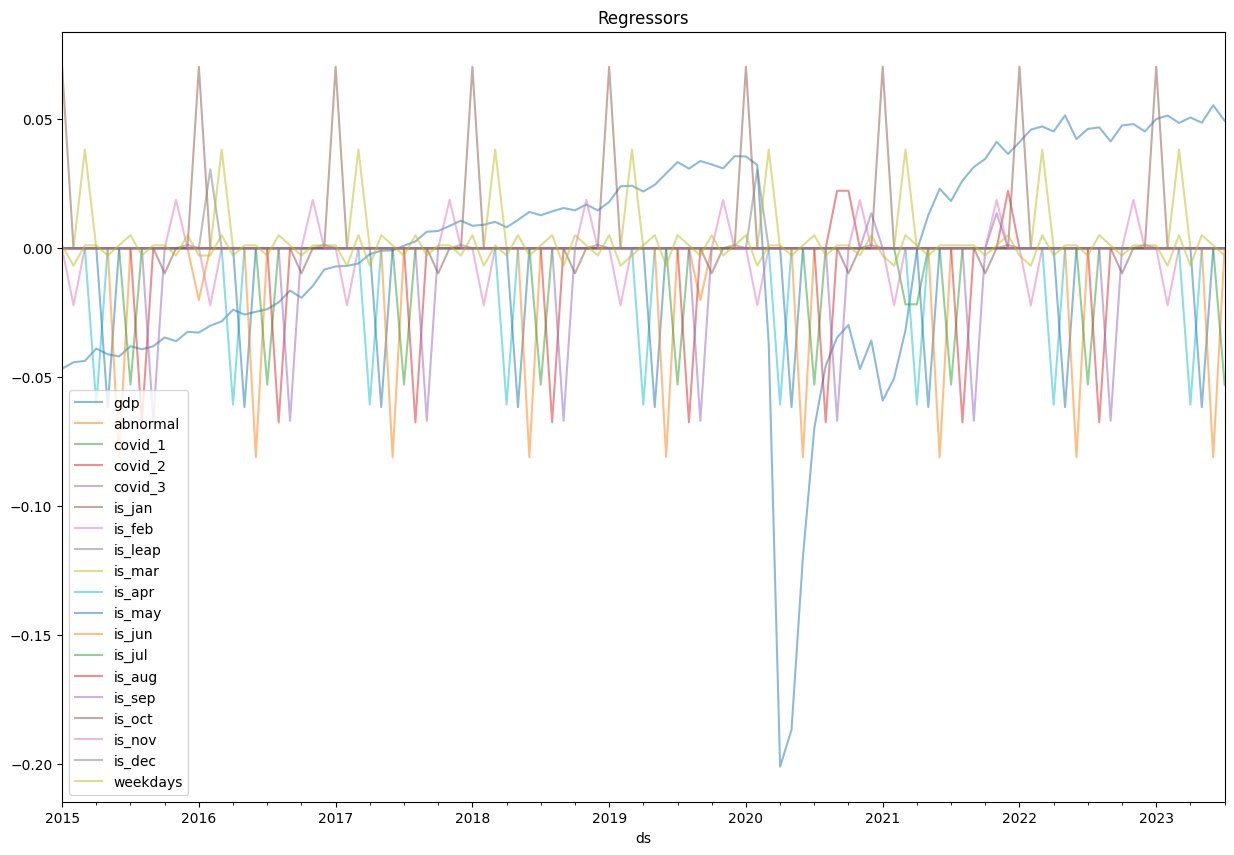

In [126]:
# Plotting Regressors' weights throughout time
fig2 = utils.plot_regressors(best_model)

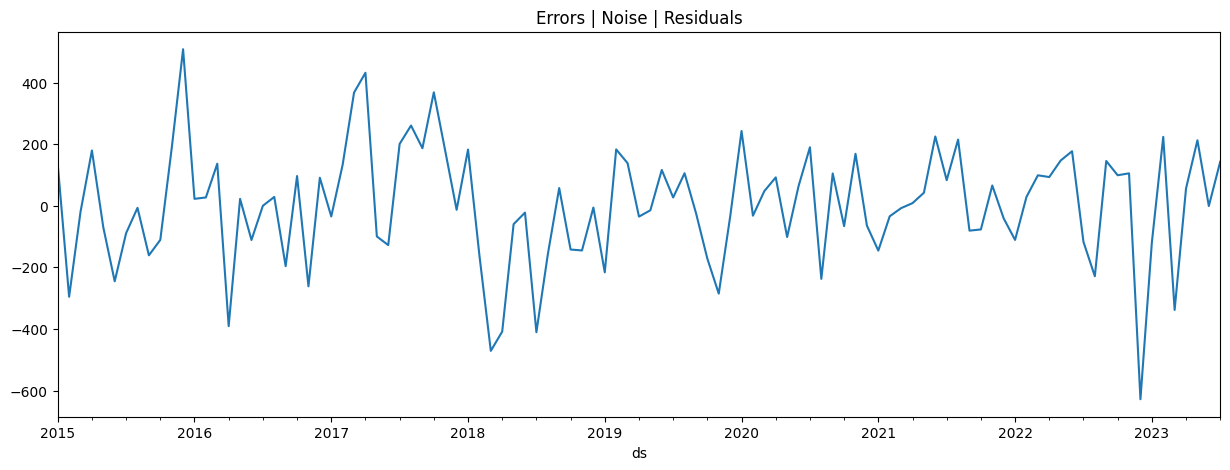

In [127]:
# Plotting Model's Noise / Errors
fig3 = utils.plot_noise_ts(best_model)

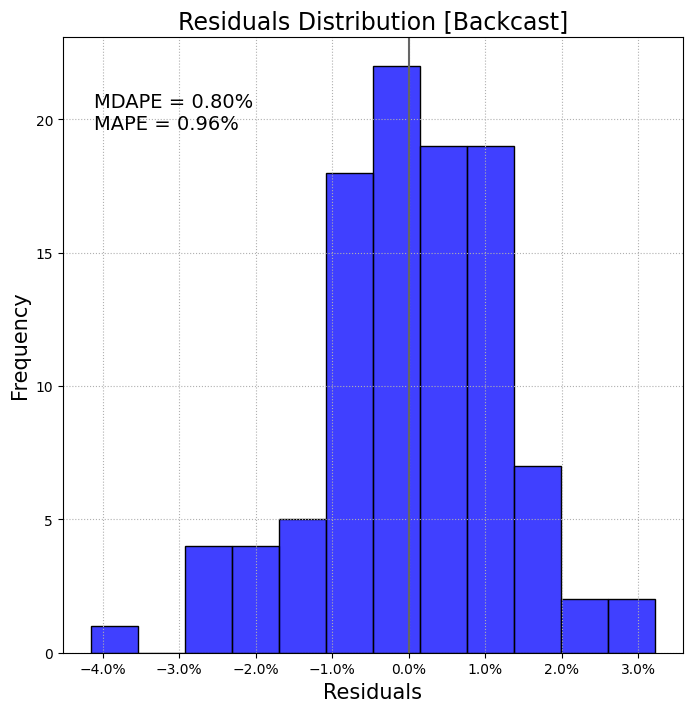

In [128]:
# Histogram of Model's Errors
fig4 = utils.plot_error_hist(best_model)

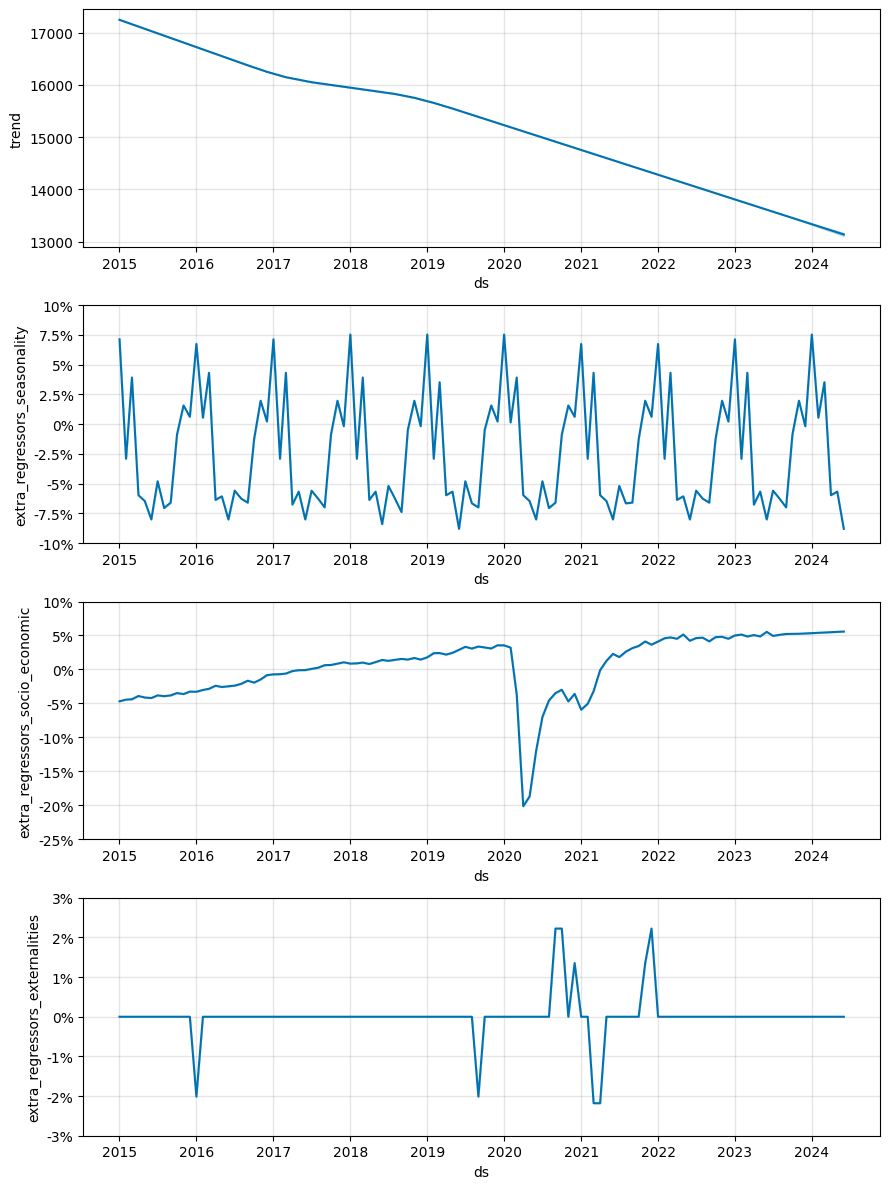

In [129]:
# Plotting components Tidely 
fig5 = utils.plot_base_components(best_model)

In [131]:
best_model.reduced_forecast.to_parquet(os.path.join(outputs_path,f"{category}_{granularity}_reduced_forecast.parquet"))
best_model.full_forecast.to_parquet(os.path.join(outputs_path,f"{category}_{granularity}_full_forecast.parquet"))

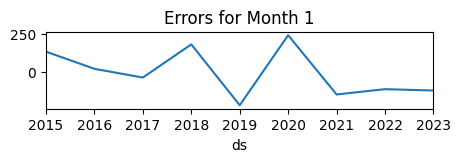

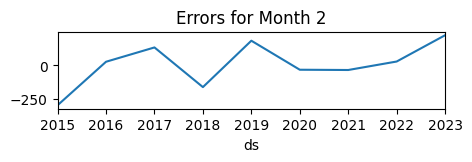

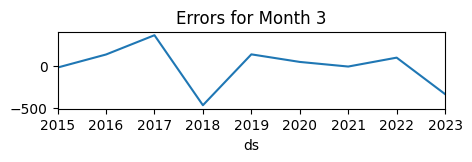

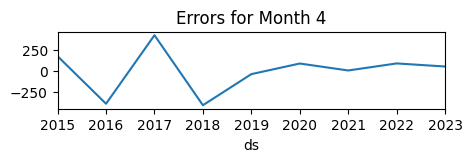

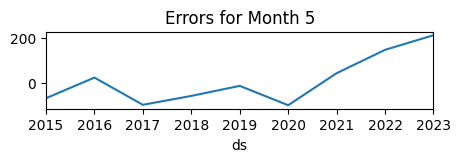

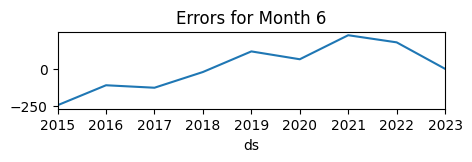

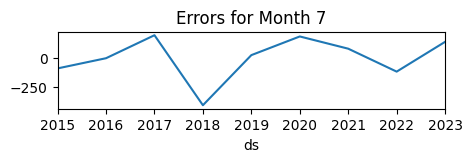

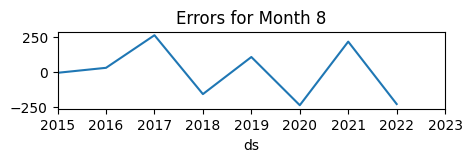

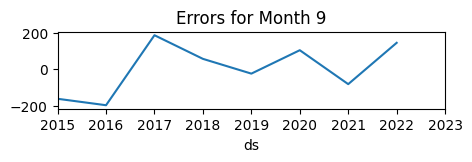

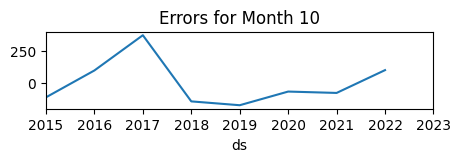

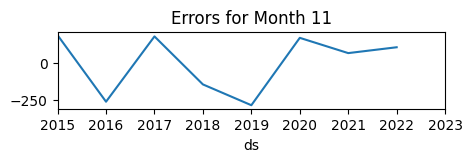

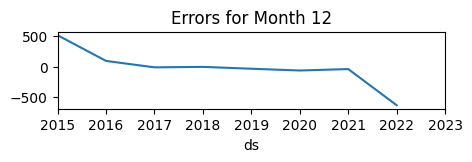

In [134]:
# Exploring noise by DOW:
# There is clearly more signals that can be retrieved from the model.

for month in range(1,13):

  error_ax = best_model.full_forecast[(best_model.full_forecast['ds'] >= '2015-01-01') & (best_model.full_forecast['ds'].dt.month == month)].dropna().set_index('ds')['residual'].plot(figsize=(
      5, 1), title=f'Errors for Month {month}', xlim=([best_model.history['ds'].min(), best_model.history['ds'].max()]))
  error_fig = error_ax.get_figure()
  plt.show()
